### Modify the file path according to your environment

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'CV_HW3/assignment3/'
FOLDERNAME = "ComputerVision/HW3"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets
!bash get_datasets.sh

%cd /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets
/content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3


# Image Captioning with LSTMs
In the previous exercise, you implemented a vanilla RNN and applied it to image captioning. In this notebook, you will implement the LSTM update rule and use it for image captioning.

In [ ]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from CV.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from CV.rnn_layers import *
from CV.captioning_solver import CaptioningSolver
from CV.classifiers.rnn import CaptioningRNN
from CV.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from CV.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# COCO Dataset
As in the previous notebook, we will use the COCO dataset for captioning.

In [ ]:
# Load COCO data from disk into a dictionary.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (376490, 17) int32
train_image_idxs <class 'numpy.ndarray'> (376490,) int32
val_captions <class 'numpy.ndarray'> (184296, 17) int32
val_image_idxs <class 'numpy.ndarray'> (184296,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 50261
word_to_idx <class 'dict'> 50261
train_urls <class 'numpy.ndarray'> (82783,) <U71
val_urls <class 'numpy.ndarray'> (40504,) <U67
nice_feature <class 'numpy.ndarray'> (1000, 4096) float32


# LSTM
A common variant on the vanilla RNN is the Long-Short Term Memory (LSTM) RNN. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task.

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$ and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: Step Forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `CV/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-8` or less.

In [ ]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131967097955e-09
next_c error:  5.8143123088804145e-09


# LSTM: Step Backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `CV/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-7` or less.

In [ ]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  3.261398431623834e-09
dh error:  2.7327025072558407e-10
dc error:  1.5221723979041107e-10
dWx error:  1.6989913110863295e-09
dWh error:  2.7311398322845992e-08
db error:  2.5828274262391835e-10


# LSTM: Forward
In the function `lstm_forward` in the file `CV/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error on the order of `e-7` or less.

In [ ]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537442272635e-08


# LSTM: Backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `CV/rnn_layers.py`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors on the order of `e-8` or less. (For `dWh`, it's fine if your error is on the order of `e-6` or less).

In [ ]:
from CV.rnn_layers import lstm_forward, lstm_backward
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  4.282359190539485e-09
dh0 error:  1.8820763975745557e-08
dWx error:  1.4475881990556828e-09
dWh error:  6.258723210101113e-07
db error:  2.676008503610984e-10


# LSTM Captioning Model

Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `CV/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference on the order of `e-10` or less.

In [ ]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    hidden_dim=H,
    cell_type='lstm',
    dtype=np.float64
)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.82445935443226
expected loss:  9.82445935443
difference:  2.261302256556519e-12


# Overfit LSTM Captioning Model on Small Data
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see a final loss less than 0.5.

base dir  /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/CV/datasets/coco_captioning
(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.829101
(Iteration 21 / 100) loss: 30.062648
(Iteration 31 / 100) loss: 14.019763
(Iteration 41 / 100) loss: 5.995457
(Iteration 51 / 100) loss: 1.819256
(Iteration 61 / 100) loss: 0.638168
(Iteration 71 / 100) loss: 0.279516
(Iteration 81 / 100) loss: 0.234096
(Iteration 91 / 100) loss: 0.124482


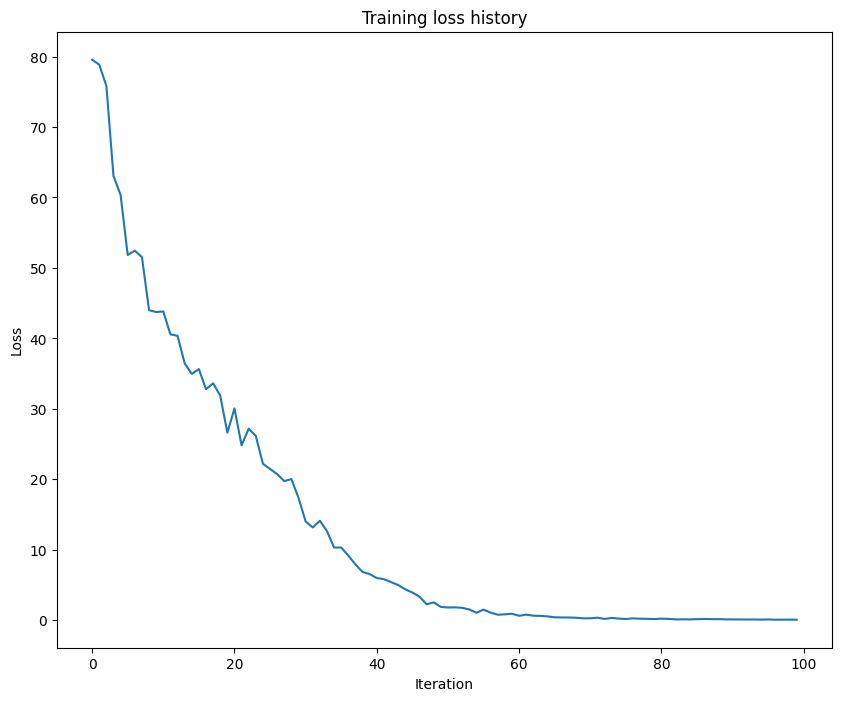

In [ ]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
    cell_type='lstm',
    word_to_idx=data['word_to_idx'],
    input_dim=data['train_features'].shape[1],
    hidden_dim=512,
    wordvec_dim=256,
    dtype=np.float32,
)

small_lstm_solver = CaptioningSolver(
    small_lstm_model, small_data,
    update_rule='adam',
    num_epochs=50,
    batch_size=25,
    optim_config={
     'learning_rate': 5e-3,
    },
    lr_decay=0.995,
    verbose=True, print_every=10,
)

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.5.

In [ ]:
print('Final loss: ', small_lstm_solver.loss_history[-1])

Final loss:  0.0798086016674987


# LSTM Sampling at Test Time
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples. As with the RNN, training results should be very good, and validation results probably won't make a lot of sense (because we're overfitting).

In [ ]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import sys
!git clone https://github.com/vrama91/cider
sys.path.append('./cider')

%cd /content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/cider/pyciderevalcap/tokenizer/

import copy
import pickle
from collections import defaultdict
import numpy as np
import math
import os

def precook(s, n=4, out=False):
    """
    Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well.
    :param s: string : sentence to be converted into ngrams
    :param n: int    : number of ngrams for which representation is calculated
    :return: term frequency vector for occuring ngrams
    """
    words = s.split()
    counts = defaultdict(int)
    for k in range(1,n+1):
        for i in range(len(words)-k+1):
            ngram = tuple(words[i:i+k])
            counts[ngram] += 1
    return counts

def cook_refs(refs, n=4): ## lhuang: oracle will call with "average"
    '''Takes a list of reference sentences for a single segment
    and returns an object that encapsulates everything that BLEU
    needs to know about them.
    :param refs: list of string : reference sentences for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (list of dict)
    '''
    return [precook(ref, n) for ref in refs]

def cook_test(test, n=4):
    '''Takes a test sentence and returns an object that
    encapsulates everything that BLEU needs to know about it.
    :param test: list of string : hypothesis sentence for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (dict)
    '''
    return precook(test, n, True)

class CiderScorer(object):
    """CIDEr scorer.
    """

    def copy(self):
        ''' copy the refs.'''
        new = CiderScorer(n=self.n)
        new.ctest = copy.copy(self.ctest)
        new.crefs = copy.copy(self.crefs)
        return new

    def __init__(self, test=None, refs=None, n=4, sigma=6.0):
        ''' singular instance '''
        self.n = n
        self.sigma = sigma
        self.crefs = []
        self.ctest = []
        self.document_frequency = defaultdict(float)
        self.cook_append(test, refs)
        self.ref_len = None

    def cook_append(self, test, refs):
        '''called by constructor and __iadd__ to avoid creating new instances.'''

        if refs is not None:
            self.crefs.append(cook_refs(refs))
            if test is not None:
                self.ctest.append(cook_test(test)) ## N.B.: -1
            else:
                self.ctest.append(None) # lens of crefs and ctest have to match

    def size(self):
        assert len(self.crefs) == len(self.ctest), "refs/test mismatch! %d<>%d" % (len(self.crefs), len(self.ctest))
        return len(self.crefs)

    def __iadd__(self, other):
        '''add an instance (e.g., from another sentence).'''

        if type(other) is tuple:
            ## avoid creating new CiderScorer instances
            self.cook_append(other[0], other[1])
        else:
            self.ctest.extend(other.ctest)
            self.crefs.extend(other.crefs)

        return self
    def compute_doc_freq(self):
        '''
        Compute term frequency for reference data.
        This will be used to compute idf (inverse document frequency later)
        The term frequency is stored in the object
        :return: None
        '''
        for refs in self.crefs:
            # refs, k ref captions of one image
            for ngram in set([ngram for ref in refs for (ngram,count) in ref.items()]):
                self.document_frequency[ngram] += 1
            # maxcounts[ngram] = max(maxcounts.get(ngram,0), count)

    def compute_cider(self, df_mode="corpus"):
        def counts2vec(cnts):
            """
            Function maps counts of ngram to vector of tfidf weights.
            The function returns vec, an array of dictionary that store mapping of n-gram and tf-idf weights.
            The n-th entry of array denotes length of n-grams.
            :param cnts:
            :return: vec (array of dict), norm (array of float), length (int)
            """
            vec = [defaultdict(float) for _ in range(self.n)]
            length = 0
            norm = [0.0 for _ in range(self.n)]
            for (ngram,term_freq) in cnts.items():
                # give word count 1 if it doesn't appear in reference corpus
                df = np.log(max(1.0, self.document_frequency[ngram]))
                # ngram index
                n = len(ngram)-1
                # tf (term_freq) * idf (precomputed idf) for n-grams
                vec[n][ngram] = float(term_freq)*(self.ref_len - df)
                # compute norm for the vector.  the norm will be used for
                # computing similarity
                norm[n] += pow(vec[n][ngram], 2)

                if n == 1:
                    length += term_freq
            norm = [np.sqrt(n) for n in norm]
            return vec, norm, length

        def sim(vec_hyp, vec_ref, norm_hyp, norm_ref, length_hyp, length_ref):
            '''
            Compute the cosine similarity of two vectors.
            :param vec_hyp: array of dictionary for vector corresponding to hypothesis
            :param vec_ref: array of dictionary for vector corresponding to reference
            :param norm_hyp: array of float for vector corresponding to hypothesis
            :param norm_ref: array of float for vector corresponding to reference
            :param length_hyp: int containing length of hypothesis
            :param length_ref: int containing length of reference
            :return: array of score for each n-grams cosine similarity
            '''
            delta = float(length_hyp - length_ref)
            # measure consine similarity
            val = np.array([0.0 for _ in range(self.n)])
            for n in range(self.n):
                # ngram
                for (ngram,count) in vec_hyp[n].items():
                    val[n] += vec_hyp[n][ngram] * vec_ref[n][ngram]

                if (norm_hyp[n] != 0) and (norm_ref[n] != 0):
                    val[n] /= (norm_hyp[n]*norm_ref[n])

                assert(not math.isnan(val[n]))
            return val

        # compute log reference length
        if df_mode == "corpus":
            self.ref_len = np.log(float(len(self.crefs)))
        elif df_mode == "coco-val-df":
            # if coco option selected, use length of coco-val set
            self.ref_len = np.log(float(40504))

        scores = []
        for test, refs in zip(self.ctest, self.crefs):
            # compute vector for test captions
            vec, norm, length = counts2vec(test)
            # compute vector for ref captions
            score = np.array([0.0 for _ in range(self.n)])
            for ref in refs:
                vec_ref, norm_ref, length_ref = counts2vec(ref)
                score += sim(vec, vec_ref, norm, norm_ref, length, length_ref)
            # change by vrama91 - mean of ngram scores, instead of sum
            score_avg = np.mean(score)
            # divide by number of references
            score_avg /= len(refs)
            # multiply score by 10
            score_avg *= 10.0
            # append score of an image to the score list
            scores.append(score_avg)
        return scores

    def compute_score(self, df_mode, option=None, verbose=0):
        # compute idf
        if df_mode == "corpus":
            self.compute_doc_freq()
            # assert to check document frequency
            assert(len(self.ctest) >= max(self.document_frequency.values()))
            # import json for now and write the corresponding files
        else:
            self.document_frequency = pickle.load(open(os.path.join('data', df_mode + '.p'),'r'))
        # compute cider score
        score = self.compute_cider(df_mode)
        # debug
        # print score
        return np.mean(np.array(score)), np.array(score)

import os
import pdb # python debugger
import sys
import subprocess
import re
import tempfile
import itertools

# path to the stanford corenlp jar
STANFORD_CORENLP_3_4_1_JAR = 'stanford-corenlp-3.4.1.jar'

# punctuations to be removed from the sentences
PUNCTUATIONS = ["''", "'", "``", "`", "-LRB-", "-RRB-", "-LCB-", "-RCB-", \
        ".", "?", "!", ",", ":", "-", "--", "...", ";"]

file_path = "/content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/cider/pyciderevalcap/tokenizer/"

class PTBTokenizer:
    """Python wrapper of Stanford PTBTokenizer"""
    def __init__(self, _source='gts'):
        self.source = _source

    def tokenize(self, captions_for_image):
        cmd = ['java', '-cp', STANFORD_CORENLP_3_4_1_JAR, \
                'edu.stanford.nlp.process.PTBTokenizer', \
                '-preserveLines', '-lowerCase']

        # ======================================================
        # prepare data for PTB Tokenizer
        # ======================================================

        if self.source == 'gts':
            image_id = [k for k, v in captions_for_image.items() for _ in range(len(v))]
            sentences = '\n'.join([c['caption'].replace('\n', ' ') for k, v in captions_for_image.items() for c in v])
            final_tokenized_captions_for_image = {}

        elif self.source == 'res':
            index = [i for i, v in enumerate(captions_for_image)]
            image_id = [v["image_id"] for v in captions_for_image]
            sentences = '\n'.join(v["caption"].replace('\n', ' ') for v in captions_for_image )
            final_tokenized_captions_for_index = []

        # ======================================================
        # save sentences to temporary file
        # ======================================================
        path_to_jar_dirname=os.path.dirname(file_path)
        tmp_file = tempfile.NamedTemporaryFile(delete=False, dir=path_to_jar_dirname)
        tmp_file.write(sentences.encode("utf-8"))
        tmp_file.close()

        # ======================================================
        # tokenize sentence
        # ======================================================
        cmd.append(os.path.basename(tmp_file.name))
        p_tokenizer = subprocess.Popen(cmd, cwd=path_to_jar_dirname, \
                stdout=subprocess.PIPE)
        token_lines = p_tokenizer.communicate(input=sentences.rstrip())[0]
        lines = token_lines.decode("utf-8").split('\n')
        # remove temp file
        os.remove(tmp_file.name)

        # ======================================================
        # create dictionary for tokenized captions
        # ======================================================
        if self.source == 'gts':
            for k, line in zip(image_id, lines):
                if not k in final_tokenized_captions_for_image:
                    final_tokenized_captions_for_image[k] = []
                tokenized_caption = ' '.join([w for w in line.rstrip().split(' ') \
                        if w not in PUNCTUATIONS])
                final_tokenized_captions_for_image[k].append(tokenized_caption)

            return final_tokenized_captions_for_image

        elif self.source == 'res':
            for k, img, line in zip(index, image_id, lines):
                tokenized_caption = ' '.join([w for w in line.rstrip().split(' ') \
                        if w not in PUNCTUATIONS])
                final_tokenized_captions_for_index.append({'image_id': img, 'caption': [tokenized_caption]})

            return final_tokenized_captions_for_index

# from cider.cider_scorer import CiderScorer
# from tokenizer.ptbtokenizer import PTBTokenizer

class Cider:
    def __init__(self, n=4, df="corpus"):
        self._n = n
        self._df = df

    def compute_score(self, gts, res):

        cider_scorer = CiderScorer(n=self._n)

        for res_id in res:

            hypo = res_id['caption']
            ref = gts[res_id['image_id']]

            # Sanity check.
            assert(type(hypo) is list)
            assert(len(hypo) == 1)
            assert(type(ref) is list)
            assert(len(ref) > 0)
            cider_scorer += (hypo[0], ref)

        (score, scores) = cider_scorer.compute_score(self._df)

        return score, scores

    def method(self):
        return "CIDEr"

class CIDErEvalCap:
    def __init__(self, gts, res, df):
        tokenizer = PTBTokenizer('gts')
        _gts = tokenizer.tokenize(gts)
        tokenizer = PTBTokenizer('res')
        _res = tokenizer.tokenize(res)
        self.gts = _gts
        self.res = _res
        self.df = df

    def evaluate(self):
        # =================================================
        # Set up scorers
        # =================================================

        scorers = [
            (Cider(df=self.df), "CIDEr")
        ]

        metric_scores = {}
        metric_score = {}
        for scorer, method in scorers:
            score, scores = scorer.compute_score(self.gts, self.res)
            metric_score[method] = score
            metric_scores[method] = list(scores)
        return metric_score, metric_scores

from collections import defaultdict
df_mode = "corpus"
gtsList = [{"image_id": "0.png", "caption": "You want some coffee?, you really want ?"}, {"image_id": "1.png", "caption": "I can't see your halo"}, {"image_id": "2.png", "caption": "this is exactly same sentence, so you have to get very high Cider Score in terms of performance, i think it works"}, {"image_id": "3.png", "caption": "this is exactly same sentence, so you have to get very high Cider Score in terms of performance, i think it works"}]
gts = defaultdict(list)
for l in gtsList:
  gts[l['image_id']].append({"caption": l['caption']})
res = [{"image_id": "0.png", "caption": "You want some extra vanila coffee?, you really want ?"}, {"image_id": "1.png", "caption": "I can see your halo"}, {"image_id": "2.png", "caption": "this is exactly same sentence, so you have to get very high Cider Score in terms of performance, i think it works"}, {"image_id": "3.png", "caption": "this is exactly same sentence, so you have to get very high Cider Score in terms of performance, i think it works"}]
scorer = CIDErEvalCap(gts, res, df_mode)
score, scores = scorer.evaluate()
print(score['CIDEr'])

fatal: destination path 'cider' already exists and is not an empty directory.
/content/drive/MyDrive/Colab Notebooks/ComputerVision/HW3/cider/pyciderevalcap/tokenizer
7.329370986532249


In [ ]:
train_feat = data["train_features"][data["train_image_idxs"]]
gts_cap_train = decode_captions(data["train_captions"], data['idx_to_word'])
res_cap_train = decode_captions(small_lstm_model.sample(train_feat), data['idx_to_word'])
gts_train = defaultdict(list)
res_train = []
for i in range(len(data['train_captions'])):
  gts_train[str(data['train_image_idxs'][i])].append({"caption" : gts_cap_train[i]})
  re_curr = dict()
  re_curr["image_id"] = str(data['train_image_idxs'][i])
  re_curr["caption"] = res_cap_train[i]
  res_train.append(re_curr)

df_mode = "corpus"
scorer_train = CIDErEvalCap(gts_train, res_train, df_mode)
score_train, scores_train = scorer_train.evaluate()
print(f"train CIDEr : {100 * score_train['CIDEr']}")

val_feat = data["val_features"][data["val_image_idxs"]]
gts_cap_val = decode_captions(data["val_captions"], data['idx_to_word'])
res_cap_val = decode_captions(small_lstm_model.sample(val_feat), data['idx_to_word'])
gts_val = defaultdict(list)
res_val = []
for i in range(len(data['val_captions'])):
  gts_val[str(data['val_image_idxs'][i])].append({"caption" : gts_cap_val[i]})
  re_curr = dict()
  re_curr["image_id"] = str(data['val_image_idxs'][i])
  re_curr["caption"] = res_cap_val[i]
  res_val.append(re_curr)

df_mode = "corpus"
scorer_val = CIDErEvalCap(gts_val, res_val, df_mode)
score_val, scores_val = scorer_val.evaluate()
print(f"val CIDEr : {100 * score_val['CIDEr']}")

train CIDEr : 9.01287024764218
val CIDEr : 8.765868450885614
